In [53]:
import pandas as pd
import torch
import torch.nn.functional as F

from datasets import load_dataset
emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

# From Text to Tokens
Transformer models like DistilBERT cannot receive raw strings as input; instead, they assume the text has been tokenized and encoded as numerical vectors. Tokenization is the step of breaking down a string into the atomic units used in the model. There are several tokenization strategies one can adopt, and the optimal splitting of words into subunits is usually learned from the corpus. Before looking at the tokenizer used for DistilBERT, let’s consider two extreme cases: character and word tokenization.

In [2]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


This is a good start, but we’re not done yet. Our model expects each character to be converted to an integer, a process sometimes called numericalization. One simple way to do this is by encoding each unique token (which are characters in this case) with a unique integer:

In [4]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


This gives us a mapping from each character in our vocabulary to a unique integer. We can now use token2idx to transform the tokenized text to a list of integers:

In [24]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


Each token has now been mapped to a unique numerical identifier (hence the name input_ids). The last step is to convert input_ids to a 2D tensor of one-hot vectors. One-hot vectors are frequently used in machine learning to encode categorical data, which can be either ordinal or nominal. 

For example, suppose we wanted to encode the names of characters in the Transformers TV series. One way to do this would be to map each name to a unique ID, as follows:

In [7]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


The problem with this approach is that it creates a **fictitious ordering** between the names, and neural networks are really good at learning these kinds of relationships. So instead, we can create a new column for each category and assign a 1 where the category is true, and a 0 otherwise. In Pandas, this can be implemented with the get_dummies() function as follows:

In [8]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows are now single **hot** vectors with 1 and 0 everywhere else. 

In [30]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings

/tmp/ipykernel_1987/1738634616.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(input_ids)


tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0,

By examining the first vector, we can verify that a 1 appears in the location indicated by input_ids[0]:

In [29]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


From our simple example we can see that character-level tokenization ignores any structure in the text and treats the whole string as a stream of characters. Although this helps deal with misspellings and rare words, the main drawback is that linguistic structures such as words need to be learned from the data. This requires significant compute, memory, and data. For this reason, character tokenization is rarely used in practice. Instead, some structure of the text is preserved during the tokenization step. Word tokenization is a straightforward approach to achieve this, so let’s take a look at how it works.

## Word Tokenization
Instead of splitting the text into characters, we can split it into words and map each word to an integer. Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. We can do this by applying Python’s split() function directly on the raw text (just like we did to measure the tweet lengths):

In [31]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


From here we can take the same steps we took for the character tokenizer to map each word to an ID. However, we can already see one potential problem with this tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single token. Given that words can include declinations, conjugations, or misspellings, the **size of the vocabulary can easily grow into the millions!**

Having a **large vocabulary** is a **problem** because it requires neural networks to have an enormous number of parameters. To illustrate this, suppose we have **1 million unique words** and want to compress the **1-million-dimensional** input vectors to **1-thousand-dimensional vectors** in the **first layer of our neural network**. This is a standard step in most NLP architectures, and the resulting **weight matrix of this first layer would contain 1 million × 1 thousand = 1 billion weights**. This is already **comparable to the largest GPT-2 model,4 which has around 1.5 billion parameters** in total!

Naturally, we want to avoid being so wasteful with our model parameters since models are expensive to train, and larger models are more difficult to maintain. A **common approach is to limit the vocabulary and discard rare words** by considering, say, the **100,000 most common words** in the corpus. Words that are not part of the vocabulary are classified as “unknown” and mapped to a shared UNK token. This means that we lose some potentially important information in the process of word tokenization, since the model has no information about words associated with UNK.

## Subword Tokenization
The basic idea behind **subword tokenization** is to **combine** the best aspects of **character and word tokenization**. On the one hand, we want to **split rare words into smaller units** to allow the model to deal with complex words and misspellings. On the other hand, we want to **keep frequent words as unique entities** so that we can keep the length of our inputs to a manageable size. The main distinguishing feature of subword tokenization (as well as word tokenization) is that it is learned from the pretraining corpus using a mix of statistical rules and algorithms.

There are several subword tokenization algorithms that are commonly used in NLP, but let’s start with **WordPiece**, which is **used by the BERT and DistilBERT tokenizers**. The easiest way to understand how WordPiece works is to see it in action. 

Transformers provides a convenient **AutoTokenizer** class that allows you to **quickly load the tokenizer associated with a pretrained model**,  we just call its **from_pretrained()** method, providing the ID of a model on the Hub or a local file path. Let’s start by loading the tokenizer for DistilBERT:

In [33]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

The **AutoTokenizer** class belongs to a larger set of **“auto” classes** whose job is to **automatically retrieve the model’s configuration, pretrained weights, or vocabulary from the name of the checkpoint**. This allows you to quickly switch between models, but **if you wish to load the specific class manually** you can do so as well. For example, we could have loaded the DistilBERT tokenizer as follows:

In [35]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
distilbert_tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [36]:
# Let’s examine how this tokenizer works by feeding it our simple “Tokenizing text is a core task of NLP.” example text:

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


Just **as with character tokenization**, we can see that the **words have been mapped to unique integers** in the input_ids field. We’ll **discuss the role of the attention_mask** field in the next section. Now that we have the input_ids, we can convert them back into tokens by using the tokenizer’s convert_ids_to_tokens() method:

We can observe three things here. First, some **special [CLS] and [SEP] tokens** have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the **start and end of a sequence**. Second, the tokens have each been **lowercased**, which is a **feature of this particular checkpoint**. Finally, we can see that “tokenizing” and “NLP” have been **split into two tokens**, which makes sense since they are **not common words**. The **## prefix** in ##izing and ##p means that the **preceding string is not whitespace**; any token with this prefix should be **merged with the previous token** when you convert the tokens back to a string. The AutoTokenizer class has a convert_tokens_to_string() method for doing just that, so let’s apply it to our tokens:

In [39]:
print(tokenizer.convert_ids_to_tokens(encoded_text.input_ids))

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [45]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenizing the Whole Dataset
To tokenize the whole corpus, we’ll use the **map() method** of our **DatasetDict object**. We’ll encounter this method many times throughout this book, as it provides a **convenient way to apply a processing function to each element in a dataset**. As we’ll soon see, the map() method can also be used to create new rows and columns.

To get started, the first thing we need is a processing function to tokenize our examples with:

In [46]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

This function applies the tokenizer to a batch of examples; padding=True will pad the examples with zeros to the size of the longest one in a batch, and truncation=True will truncate the examples to the model’s maximum context size. To see tokenize() in action, let’s **pass a batch of two examples** from the training set:

In [110]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


By default, the map() method operates individually on every example in the corpus, so setting batched=True will encode the tweets in batches. Because we’ve set batch_size=None, our tokenize() function will be applied on the full dataset as a single batch. This ensures that the input tensors and attention masks have the same shape globally, and we can see that this operation has **added new input_ids and attention_mask columns** to the dataset:

In [111]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
print(emotions_encoded["train"].column_names)

Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-4ad8cf602e7e0c67.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-bc8335e86e852ab2.arrow
Loading cached processed dataset at /home/jerdavies/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-a58e5c638054978e.arrow


['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

We can’t use these language models directly for text classification; we need to modify them slightly. 

To understand what modifications are necessary, let’s take a look at the architecture of an encoder-based model like DistilBERT, which is depicted in Figure 2-4.

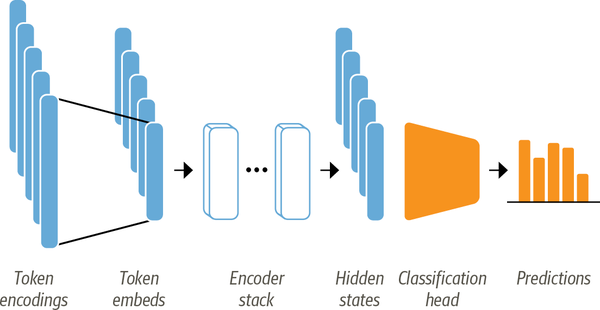

1. First, the text is **tokenized** and represented as **one-hot vectors** called token **encodings**. 

2. The size of the tokenizer vocabulary determines the dimension of the token encodings, and it usually consists of 20k–200k unique tokens. 

3. Next, these **token encodings** are converted to **token embeddings**, which are **vectors** living in a **lower-dimensional space**. 

4. The **token embeddings** are then passed through the **encoder block** layers to **yield a hidden state** for each **input token**. 

5. For the pretraining objective of language modeling,⁠ each **hidden state** is fed to a layer that predicts the **masked input tokens**. 

6. For the classification task, we **replace** the language modeling layer with a **classification layer**.

We have two options to train such a model on our Twitter dataset:

- Feature extraction

We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.

- Fine-tuning

We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In the following sections we explore both options for DistilBERT and examine their trade-offs.

## Transformers as Feature Extractors
Using a transformer as a feature extractor is fairly simple. We freeze the body’s weights during training and use the hidden states as features for the classifier. The advantage of this approach is that we can quickly train a small or shallow model. Such a model could be a neural classification layer or a method that does not rely on gradients, such as a random forest. This method is especially convenient if GPUs are unavailable, since the hidden states only need to be precomputed once.

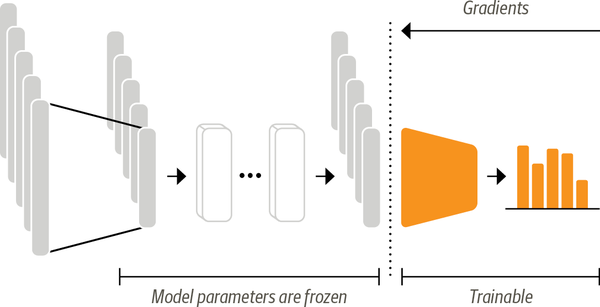!

## Using pretrained models
We will use another convenient auto class from Transformers called **AutoModel**. Similar to the **AutoTokenizer** class, **AutoModel** has a **from_pretrained()** method to load the weights of a pretrained model. 

Let’s use this method to load the DistilBERT checkpoint:

In [113]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Here we’ve used PyTorch to check whether a GPU is available or not, and then chained the **PyTorch nn.Module.to()** method to the model loader. 

This ensures that the model will run on the GPU if we have one. If not, the model will run on the CPU, which can be considerably slower.

The **AutoModel** class converts the **token encodings** to **embeddings**, and then feeds them **through the encoder stack to return the hidden states**. 

Let’s take a look at how we can extract these states from our corpus.

## Extracting the last hidden states
To warm up, let’s **retrieve the last hidden states for a single string**. 

The first thing we need to do is **encode** the string and **convert** the tokens **to PyTorch tensors**. This can be done by providing the **return_tensors="pt"** argument to the tokenizer as follows:

In [118]:
text = "this is a test"
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}